# First steps with SYGMA

调用函数

In [1]:
from NuPyCEE import sygma as s
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import quad
import os
import sys

## 1. The initial mass function

直接计算产出与模拟结果的对比（基于Salpeter IMF，设置恒星质量范围为 [1,30] ，形成的恒星总质量为1e11,每个恒星的产出为0.1 Msun ）

In [19]:
k_N=1e11*0.35/(1**(-0.35)-30**(-0.35))
N_tot=k_N*(1**(-1.35)-30**(-1.35))/1.35
Yield_tot=0.1*N_tot
print(Yield_tot/1e11)

0.03687728129719034


通过模拟计算上述产出

In [45]:
s1=s.sygma(iolevel=0,mgal=1e11,dt=1e7,imf_type='salpeter',imf_bdys=[1,30],iniZ=0.02,hardsetZ=0.02,
           table='yield_tables/agb_and_massive_stars_h1.txt',sn1a_on=False, 
           iniabu_table='yield_tables/iniabu/iniab_h1.ppn',pop3_table='yield_tables/popIII_h1.txt')
Yield_tot_sim=s1.history.ism_iso_yield[-1][0]
print(Yield_tot_sim)

SYGMA run in progress..
   SYGMA run completed - Run time: 0.02s
3687728129.719033


使用原文件报错：
Error-Model(M=12.0,Z=0.02) not found in myposition/NuPyCEE/yield_tables/agb_and_massive_stars_h1.txt
Error-Model(M=12.0,Z=0.01) not found in myposition/NuPyCEE/yield_tables/agb_and_massive_stars_h1.txt
我找到了这个文件并在其中加入了M=12,Z=0.02和M=12,Z=0.01，（后面表格内容复制了M=7.0的内容，应该需要查询一下正确数值）不再报错，且结果与正确结果只差0.00001.
猜测可能是某次更新时不小心删去了这一段。

In [4]:
print('ratio should be 1 : ',Yield_tot_sim/Yield_tot)

ratio should be 1 :  0.9999999999999997


对于不同的IMF的范围模拟是否一致

In [5]:
k_N_5_20=1e11*0.35/ (5**-0.35 - 20**-0.35)
N_tot=k_N_5_20/1.35 * (5**-1.35 - 20**-1.35)
Yield_tot=0.1*N_tot
print(Yield_tot/1e11)

0.01141234138041294


In [6]:
s1_5_20=s.sygma(iolevel=0,mgal=1e11,dt=1e9,tend=1.3e10,imf_type='salpeter',
                imf_bdys=[5,20],iniZ=0.02,hardsetZ=0.02,table='yield_tables/agb_and_massive_stars_h1.txt',sn1a_on=False, 
                iniabu_table='yield_tables/iniabu/iniab_h1.ppn')
Yield_tot_sim=s1_5_20.history.ism_iso_yield[-1][0]
print(Yield_tot_sim/1e11)

SYGMA run in progress..
   SYGMA run completed - Run time: 0.03s
0.11725579801493773


In [7]:
print('ratio should be 1 : ',Yield_tot_sim/Yield_tot)

ratio should be 1 :  10.274473406148228


答案与标准相差太大，可能是由于之前的数值不标准的缘故。尝试在徐平的代码内再次计算，没有报错且结果与此相同，检查后发现他并没有更改我所更改的文件，仔细观察后发现他改变了报错处引用的函数，将函数放在外面了，因此调用的函数不再是self.而变成了一个独立的函数。引用其他的产值列表也会导致误差。

改变agb和大质量恒星的分界线不会改变结果，因为产值比例不变。

展示此时的s1随时间的演化

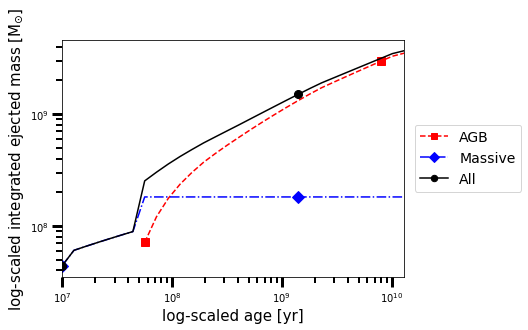

In [8]:
s1.plot_totmasses(source='agb')
s1.plot_totmasses(source='massive')
s1.plot_totmasses(source='all')

 这幅图与教程中的图也完全不同。可能原因与上一个原因相同。在徐平的版本中此图与教程一致。

In [9]:
s1_evol=s.sygma(iolevel=0,mgal=1e11,dt=1e7,tend=1.3e10,imf_type='salpeter',alphaimf=2.35,
                imf_bdys=[1,30],iniZ=0,hardsetZ=0.0001,table='yield_tables/agb_and_massive_stars_h1.txt',sn1a_on=False, 
                iniabu_table='yield_tables/iniabu/iniab_h1.ppn')

SYGMA run in progress..
   SYGMA run completed - Run time: 0.03s


s1=s.sygma(iolevel=0,mgal=1e11,dt=1e7,imf_type='salpeter',imf_bdys=[1,30],iniZ=0.02,hardsetZ=0.02,
           table='yield_tables/agb_and_massive_stars_h1.txt',sn1a_on=False, sn1a_table='yield_tables/sn1a_h1.txt', 
           iniabu_table='yield_tables/iniabu/iniab_h1.ppn',pop3_table='yield_tables/popIII_h1.txt')

改变了计算时长，初始金属丰度，hardsetZ，删除了pop3_table。

对于手动计算k_N和M_tot的公式没有影响。

In [10]:
k_N_evol=1e11*0.35/(1**(-0.35)-30**(-0.35))

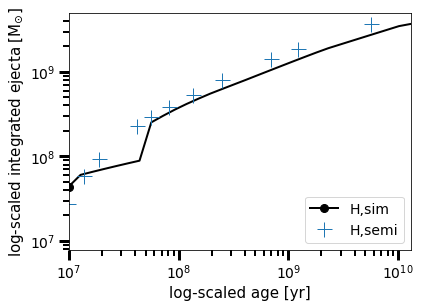

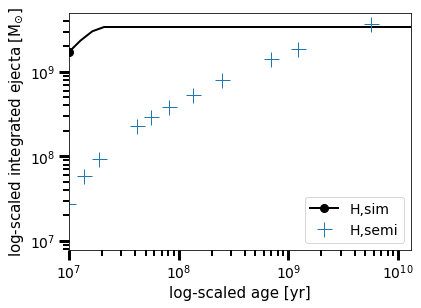

In [17]:
s1.plot_mass(fig=2,specie='H',label='H,sim',color='k',shape='-',marker='o',markevery=800)
m=[1,1.65,2,3,4,5,6,7,12,15,20,25]
ages=[5.67e9,1.211e9,6.972e8,2.471e8,1.347e8,8.123e7,5.642e7,4.217e7,1.892e7,1.381e7,9.895e6,7.902e6]
def yields(m,k_N_evol):
    return ( k_N_evol/1.35 * (m**-1.35 - 30**-1.35) ) *0.1
yields1=[]
for m1 in m:
    yields1.append(yields(m1,k_N_evol))
plt.plot(ages,yields1,marker='+',linestyle='',markersize=15,label='H,semi')
plt.legend(loc=4)

#此处尝试了s1和s1_evol的区别，初步猜测可能是由于初始金属丰度的变化导致。

s1_evol.plot_mass(fig=3,specie='H',label='H,sim',color='k',shape='-',marker='o',markevery=800)
m=[1,1.65,2,3,4,5,6,7,12,15,20,25]
ages=[5.67e9,1.211e9,6.972e8,2.471e8,1.347e8,8.123e7,5.642e7,4.217e7,1.892e7,1.381e7,9.895e6,7.902e6]
def yields(m,k_N_evol):
    return ( k_N_evol/1.35 * (m**-1.35 - 30**-1.35) ) *0.1
yields1=[]
for m1 in m:
    yields1.append(yields(m1,k_N_evol))
plt.plot(ages,yields1,marker='+',linestyle='',markersize=15,label='H,semi')
plt.legend(loc=4)

此处表明，产出对时间的函数主要基于假设不同质量的恒星在多大年龄时开始向外喷射物质。此函数模拟的是所有的恒星的产出均为恒星质量的0.1倍。
标志是计算结果，曲线为模拟结果。无法拟合应该仍然是之前的原因。

接下来对Chabrier IMF进行计算，假设质量范围为[0.01,30]

In [12]:
def imf_times_m(mass):
    if mass<=1:
        return 0.158 * np.exp( -np.log10(mass/0.08)**2/(2*0.69**2))
    else:
        return mass*0.0443*mass**(-2.3) #0.0443从何而来？
k_N_ch=1e11/ (quad(imf_times_m,0.01,30)[0] ) #末尾的[0]有什么意义？

In [20]:
N_tot=k_N_ch/1.3*0.0443*(1**-1.3 - 30**-1.3)
Yield_tot=N_tot * 0.1

只有质量在1 Msun 以上的恒星才会有产出，且每个恒星的产出均为 0.1 Msun

In [46]:
s1_ch2=s.sygma(iolevel=0,mgal=1e11,dt=1e7,tend=1.3e10,imf_type='chabrier',imf_bdys=[0.01,30],
               hardsetZ=0.0001,table='yield_tables/agb_and_massive_stars_h1.txt',sn1a_on=False,
               iniabu_table='yield_tables/iniabu/iniab_h1.ppn')
s1_ch1=s.sygma(iolevel=0,mgal=1e11,dt=1e9,tend=1.3e10,imf_type='chabrier',imf_bdys=[0.01,30],
               hardsetZ=0.0001,table='yield_tables/agb_and_massive_stars_h1.txt',sn1a_on=False,
               iniabu_table='yield_tables/iniabu/iniab_h1.ppn')
Yield_tot_sim=s1_ch.history.ism_iso_yield[-1][0]

SYGMA run in progress..
   SYGMA run completed - Run time: 0.03s
SYGMA run in progress..
   SYGMA run completed - Run time: 0.04s


In [47]:
print(Yield_tot)
print(Yield_tot_sim)
print('should be 1:', Yield_tot/Yield_tot_sim)

1838839190.786374
1844499958.2230012
should be 1: 0.9969310015913035


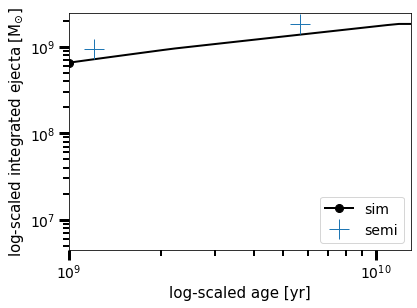

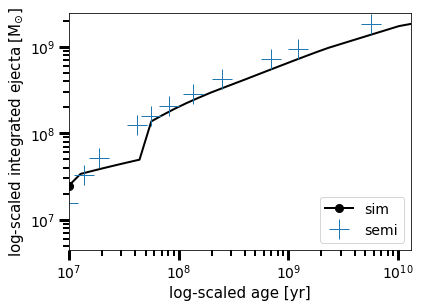

In [48]:
s1_ch1.plot_mass(fig=4,specie='H',label='sim',color='k',shape='-',marker='o',markevery=800)
m=[1,1.65,2,3,4,5,6,7,12,15,20,25]
ages=[5.67e9,1.211e9,6.972e8,2.471e8,1.347e8,8.123e7,5.642e7,4.217e7,1.892e7,1.381e7,9.895e6,7.902e6]
def yields(m,k_N_ch):
    return (k_N_ch/1.3 * 0.0443*(m**-1.3 - 30.**-1.3)) * 0.1
yields1=[]
for m1 in m:
    yields1.append(yields(m1,k_N_ch))
plt.plot(ages,yields1,marker='+',linestyle='',markersize=20,label='semi')
plt.legend(loc=4)

s1_ch2.plot_mass(fig=5,specie='H',label='sim',color='k',shape='-',marker='o',markevery=800)
m=[1,1.65,2,3,4,5,6,7,12,15,20,25]
ages=[5.67e9,1.211e9,6.972e8,2.471e8,1.347e8,8.123e7,5.642e7,4.217e7,1.892e7,1.381e7,9.895e6,7.902e6]
def yields(m,k_N_ch):
    return (k_N_ch/1.3 * 0.0443*(m**-1.3 - 30.**-1.3)) * 0.1
yields1=[]
for m1 in m:
    yields1.append(yields(m1,k_N_ch))
plt.plot(ages,yields1,marker='+',linestyle='',markersize=20,label='semi')
plt.legend(loc=4)

## 2. Supernova

In [30]:
s1_sn1a=s.sygma(iolevel=0,mgal=1e11,dt=1e7,tend=1.3e10,sn1a_on=True,sn1a_rate='maoz',
                imf_type='salpeter',imf_bdys=[1,30],hardsetZ=0.0001,table='yield_tables/agb_and_massive_stars_h1.txt', 
                sn1a_table='yield_tables/sn1a_h1.txt', iniabu_table='yield_tables/iniabu/iniab_h1.ppn')

SYGMA run in progress..
   SYGMA run completed - Run time: 0.03s


sn1a_rate是指SN Ia的延迟时间的分布函数，表示的应当是SN Ia的比例随时间的变化，默认值为power law

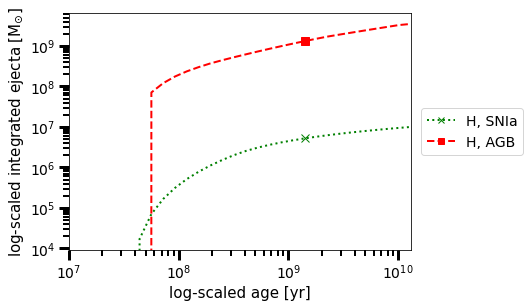

In [31]:
s1_sn1a.plot_mass(fig=6,specie='H',source='sn1a')
s1_sn1a.plot_mass(fig=6,specie='H',source='agb')

In [36]:
print (sum(s1_sn1a.history.ism_elem_yield_1a[-1]),sum(s1_sn1a.history.ism_iso_yield_1a[-1]),sum(s1_sn1a.history.ism_elem_yield[-1]))

10000000.0 10000000.0 3697728129.719033


## 3. Basic parameter

### a. Total mass

In [42]:
s1_1e7=s.sygma(iolevel=0,mgal=1e7,dt=1e7,tend=1.3e10,hardsetZ=0.0001,
               table='yield_tables/agb_and_massive_stars_h1.txt',sn1a_on=False,
               iniabu_table='yield_tables/iniabu/iniab_h1.ppn')
s1_1e9=s.sygma(iolevel=0,mgal=1e9,dt=1e9,tend=1.3e10,hardsetZ=0.0001,
               table='yield_tables/agb_and_massive_stars_h1.txt',sn1a_on=False,
               iniabu_table='yield_tables/iniabu/iniab_h1.ppn')

SYGMA run in progress..
   SYGMA run completed - Run time: 0.03s
SYGMA run in progress..
   SYGMA run completed - Run time: 0.04s


In [43]:
print (sum(s1_1e7.history.ism_elem_yield[-1])/1e7,sum(s1_1e9.history.ism_elem_yield[-1])/1e9)

0.017058370838842353 0.01705837083884235


使用简单的Salpeter型IMF时，产出质量分数应该与初始气体总质量无关

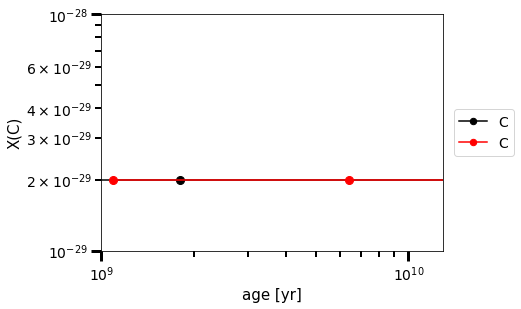

In [44]:
s1_1e7.plot_massfrac(fig=7,xaxis='age',yaxis='C',norm='no',color='k')
s1_1e9.plot_massfrac(fig=7,xaxis='age',yaxis='C',norm='no',color='r')

此处似乎所有元素的时间演化都是直线。目前还不清楚原因。

### b. Transition mass

AGB和大质量恒星的分界处质量

In [53]:
s1_8=s.sygma(iolevel=0,imf_bdys=[1,30],imf_type='salpeter',transitionmass=8,mgal=1e11,dt=1e7,
             tend=1.3e10,iniZ=0.02,hardsetZ=0.0001,
             table='yield_tables/agb_and_massive_stars_h1.txt',sn1a_on=False, sn1a_table='yield_tables/sn1a_h1.txt', 
             iniabu_table='yield_tables/iniabu/iniab_h1.ppn')
s1_10=s.sygma(iolevel=0,imf_bdys=[1,30],imf_type='salpeter',transitionmass=10,mgal=1e11,dt=1e7,
              tend=1.3e10,iniZ=0.02,hardsetZ=0.0001,
              table='yield_tables/agb_and_massive_stars_h1.txt',sn1a_on=False, sn1a_table='yield_tables/sn1a_h1.txt', 
              iniabu_table='yield_tables/iniabu/iniab_h1.ppn')

SYGMA run in progress..
   SYGMA run completed - Run time: 0.03s
SYGMA run in progress..
   SYGMA run completed - Run time: 0.03s


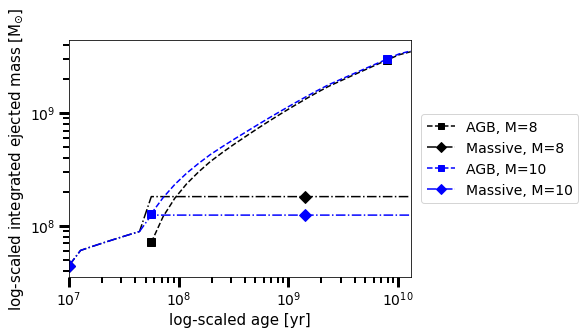

In [54]:
s1_8.plot_totmasses(fig=8,source='agb',label='AGB, M=8',color='k')
s1_8.plot_totmasses(fig=8,source='massive',label='Massive, M=8',color='k')
s1_10.plot_totmasses(fig=8,source='agb',label='AGB, M=10',color='b')
s1_10.plot_totmasses(fig=8,source='massive',label='Massive, M=10',color='b')

In [55]:
Yield_agb_sim_8=s1_8.history.ism_iso_yield_agb[-1][0]
Yield_agb_sim_10=s1_10.history.ism_iso_yield_agb[-1][0]
alpha=2.35
k_N_t=1e11*(alpha-2.)/ (1.**-(alpha-2.) - 30.**-(alpha-2.))
N_agb_8=k_N_t/(alpha-1.) * (1.**-(alpha-1.) - 8.**-(alpha-1.))
Yield_agb_8=0.1*N_agb_8
N_agb_10=k_N_t/(alpha-1) * (1.**-(alpha-1.) - 10.**-(alpha-1.))
Yield_agb_10=0.1*N_agb_10
print ('Should be 1:',Yield_agb_sim_8/Yield_agb_8)
print ('Should be 1:',Yield_agb_sim_10/Yield_agb_10)

Should be 1: 1.0016410408236358
Should be 1: 1.0012216485229783


模拟计算AGB的产出，方法和之前一样。之前就是将所有的恒星都看作最后成为AGB，每个AGB产出 0.1 Msun。

### c. Time resolution

In [56]:
s1_dt_const=s.sygma(iolevel=0,mgal=1e11,dt=1e7,tend=1.3e10,special_timesteps=-1,imf_type='salpeter',
                    imf_bdys=[1,30],hardsetZ=0.0001,table='yield_tables/agb_and_massive_stars_h1.txt',sn1a_on=False, 
                    iniabu_table='yield_tables/iniabu/iniab_h1.ppn',stellar_param_on=False)
s1_dt_log=s.sygma(iolevel=0,mgal=1e11,dt=1e7,tend=1.3e10,special_timesteps=200,imf_type='salpeter',
                  imf_bdys=[1,30],hardsetZ=0.0001,table='yield_tables/agb_and_massive_stars_h1.txt',sn1a_on=False, 
                  iniabu_table='yield_tables/iniabu/iniab_h1.ppn')

SYGMA run in progress..
   SYGMA run completed - Run time: 1.24s
SYGMA run in progress..
   SYGMA run completed - Run time: 0.19s


special_timesteps表示特殊步长的数目，小于等于0时无效。默认值为30.

In [57]:
print ('should be 1 ',s1_dt_const.history.ism_iso_yield[-1][0]/s1_dt_log.history.ism_iso_yield[-1][0])

should be 1  0.9999999999999993


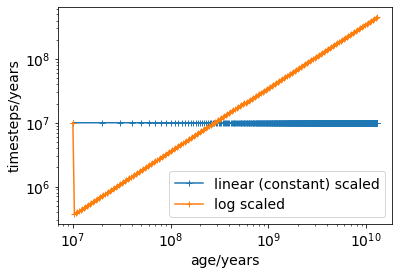

In [60]:
plt.figure(9)
plt.plot(s1_dt_const.history.age[1:],s1_dt_const.history.timesteps,label='linear (constant) scaled',marker='+')
plt.plot(s1_dt_log.history.age[1:],s1_dt_log.history.timesteps,label='log scaled',marker='+')
plt.yscale('log')
plt.xscale('log')
plt.xlabel('age/years')
plt.ylabel('timesteps/years')
plt.legend(loc=4)

history.age比history.timesteps多一位，第一位定义为0

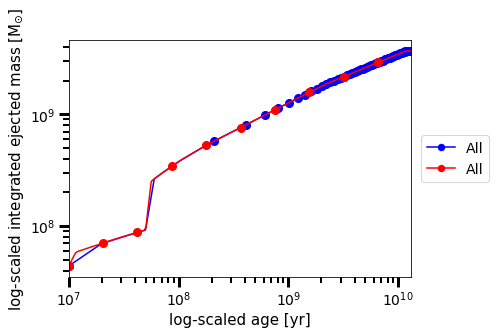

In [64]:
s1_dt_const.plot_totmasses(fig=10,color='b')
s1_dt_log.plot_totmasses(fig=10,color='r')

## 4. Neutron stars

In [63]:
s1_ns_merger=s.sygma(mgal=1e11,dt=1e7,iniZ=0.02,hardsetZ=0.02,special_timesteps=-1,
                     ns_merger_on=True, nsmerger_table = 'yield_tables/r_process_rosswog_2014.txt')
s1_default=s.sygma(mgal=1e11,dt=1e7,iniZ=0.02,hardsetZ=0.02,special_timesteps=-1,
                   ns_merger_on=False)

SYGMA run in progress..
   SYGMA run completed - Run time: 1.3s
SYGMA run in progress..
   SYGMA run completed - Run time: 1.27s


教程中还有一个选项 bhns_merger_on ，但在现在的chem_evol.py中没有这个选项了，并且也找不到相似的选项

(10000000.0, 15000000000.0)

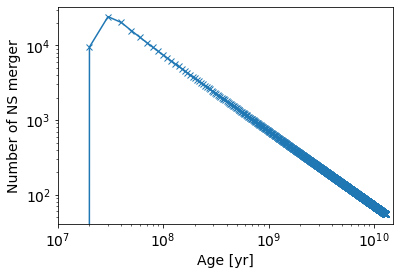

In [68]:
plt.figure(11)
plt.plot(s1_ns_merger.history.age[1:],s1_ns_merger.nsm_numbers,marker='x')
plt.plot(s1_default.history.age[1:],s1_default.nsm_numbers,marker='+',color='r')
plt.xscale('log');plt.yscale('log');
plt.ylabel('Number of NS merger'); plt.xlabel('Age [yr]')
plt.xlim(1e7,15e9)

(5000000.0, 13000000000.0)

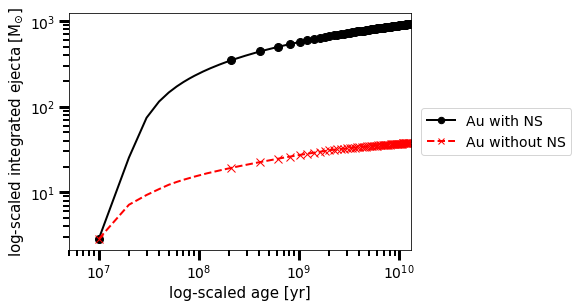

In [69]:
s1_ns_merger.plot_mass(fig=12,specie='Au',label='Au with NS')
s1_default.plot_mass(fig=12,specie='Au',label='Au without NS',marker='x',color='r',shape='--')
plt.xlim(5e6,13e9)

(5000000.0, 13000000000.0)

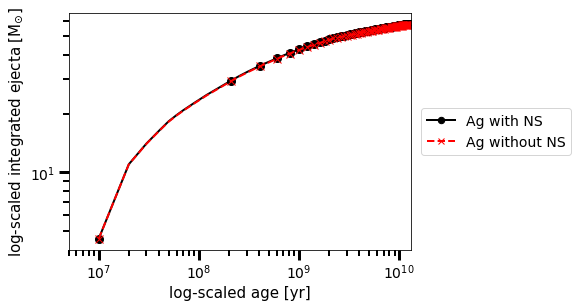

In [74]:
s1_ns_merger.plot_mass(fig=12,specie='Ag',label='Ag with NS')
s1_default.plot_mass(fig=12,specie='Ag',label='Ag without NS',marker='x',color='r',shape='--')
plt.xlim(5e6,13e9)

目前看来似乎中子星并合只会影响金的丰度